# Final Project - Aditya Singh 
---------- ASTR 19-----------

Loading Libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sep
from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval, LinearStretch

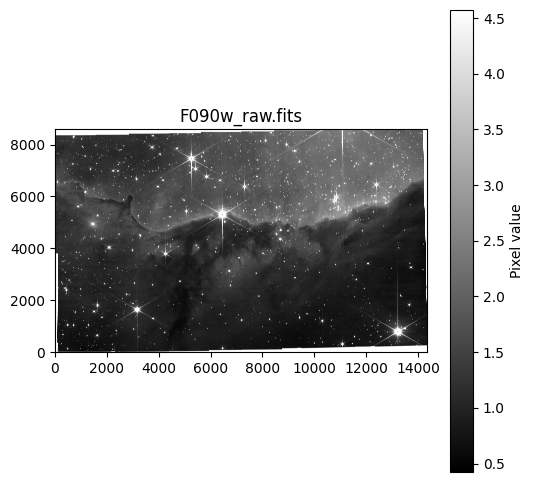

In [14]:
with fits.open("jw02731-o001_t017_nircam_clear-f090w_i2d.fits") as hdul:
    img_f090w = hdul['SCI'].data.astype(np.float32)

norm = ImageNormalize(img_f090w, interval=ZScaleInterval(), stretch=LinearStretch())

plt.figure(figsize=(6, 6))
plt.imshow(img_f090w, cmap="gray", origin="lower", norm = norm)
plt.colorbar(label="Pixel value")
plt.title("F090w_raw.fits")
plt.savefig("F090w_Raw.png")
plt.show()


Load the backround of the image into bkg, and the noise into bog_image to then subtract from the original image.

1.1997147798538208
0.06582547724246979


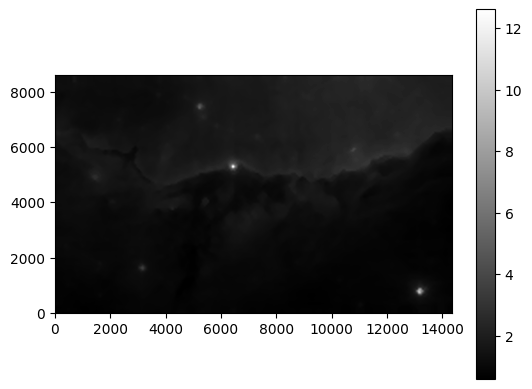

In [10]:
bkg = sep.Background(img_f090w)
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)
bkg_image = bkg.back()
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.savefig("F090w_bkg.png")
plt.colorbar();

After having the backround you then find the noise in the backround and remove that from the backround so you can easily detect objects without flagging noise 

The amount of sources found:12005


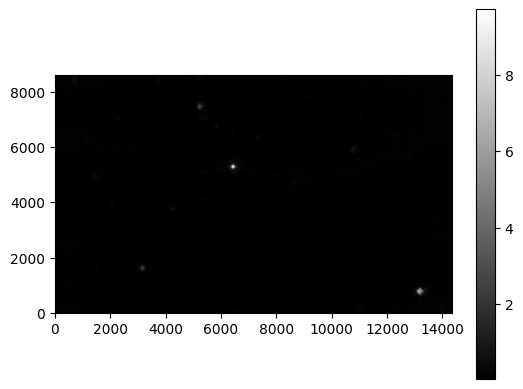

In [11]:
bkg_rms = bkg.rms()
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
data_sub = img_f090w - bkg
objects = sep.extract(data_sub, 10, err = bkg.globalrms)
#How many objects detected 
num_sources_f090w = len(objects)
plt.savefig("F090w_bkg_noise_rmv.png")
print(f"The amount of sources found:{num_sources_f090w}")

After removing noise you then subtract the noise-removed backround from the original image and run print the image with ellipses around every object detected 

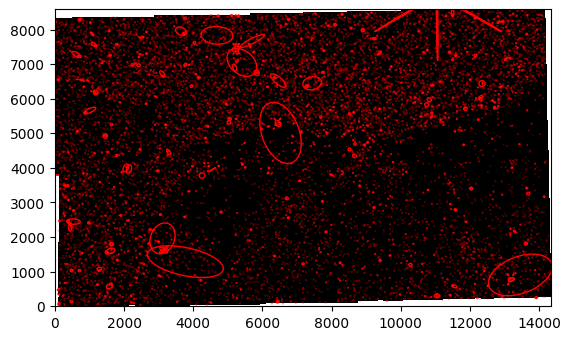

In [15]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)


After Circling all objects with ellipses, we can use the object data to caclulated fluxes and describe the data visually by creating graphs.

In [16]:
# Perform aperture photometry
flux_f090w, flux_err_f090w, flag_f090w = sep.sum_circle(
    data_sub, 
    objects['x'], 
    objects['y'],
    3.0, 
    err=bkg.globalrms, 
    gain=1.0 
)

#Printing the flux values
for i in range(min(10, num_sources_f090w)):
    print(f"Object {i}: flux = {flux_f090w[i]:.4f} +/- {flux_err_f090w[i]:.4f}, flag = {flag_f090w[i]}")

Object 0: flux = 36.5899 +/- 6.0591, flag = 0
Object 1: flux = 11.5852 +/- 3.4216, flag = 0
Object 2: flux = 249.5756 +/- 15.8018, flag = 0
Object 3: flux = 36.3260 +/- 6.0372, flag = 0
Object 4: flux = 474.4042 +/- 21.7836, flag = 0
Object 5: flux = 15.1550 +/- 3.9086, flag = 0
Object 6: flux = 56.9668 +/- 7.5558, flag = 0
Object 7: flux = 80.4410 +/- 8.9757, flag = 0
Object 8: flux = 21.4006 +/- 4.6393, flag = 0
Object 9: flux = 15.4154 +/- 3.9419, flag = 0


Creating histogram 

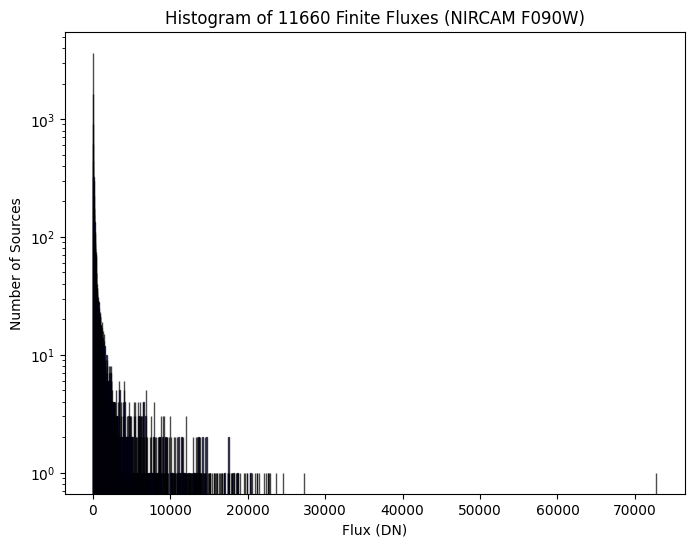

In [ ]:
finite_fluxes_for_hist = flux_f090w[np.isfinite(flux_f090w)]

plt.figure(figsize=(8, 6))
plt.hist(finite_fluxes_for_hist, bins='auto', color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Flux (DN)")
plt.ylabel("Number of Sources")
plt.title(f"Histogram of {len(finite_fluxes_for_hist)} Finite Fluxes (NIRCAM F090W)")
plt.savefig("F090w_flux_histogram.png")
plt.show()

Flux distribution statistics

In [18]:
mean_flux_f090w = np.nanmean(flux_f090w)
median_flux_f090w = np.nanmedian(flux_f090w)
std_dev_flux_f090w = np.nanstd(flux_f090w)

print(f"\nFlux Distribution Statistics:")
print(f"Number of sources with finite flux: {len(finite_fluxes_for_hist)}")
print(f"Mean Flux: {mean_flux_f090w:.2f}")
print(f"Median Flux: {median_flux_f090w:.2f}")
print(f"Standard Deviation of Flux: {std_dev_flux_f090w:.2f}")

# Find the largest outlier among finite fluxes
max_flux_f090w_val = np.nanmax(flux_f090w)
print(f"Largest Outlier of flux: {max_flux_f090w_val}")
dis_of_outlier = ((max_flux_f090w_val - mean_flux_f090w) / std_dev_flux_f090w)
print(f"The largest flux is {dis_of_outlier} std. deviations away from mean")


Flux Distribution Statistics:
Number of sources with finite flux: 11660
Mean Flux: 642.66
Median Flux: 56.77
Standard Deviation of Flux: 2227.06
Largest Outlier of flux: 72769.94941894533
The largest flux is 32.38679407526734 std. deviations away from mean


Reprojecting all files

In [17]:
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

# ---------------------------------
# 1. Load your reference image
#    This will define the WCS and shape for all others
# ---------------------------------
file_reference = "jw02731-o001_t017_nircam_clear-f090w_i2d.fits"
with fits.open(file_reference) as hdulist:
    # For JWST i2d images, 'SCI' is commonly the science extension
    ref_header = hdulist['SCI'].header
    ref_data = hdulist['SCI'].data

# Create a WCS object from the reference
ref_wcs = WCS(ref_header)

# This shape will be used for all reprojected images
output_shape = ref_data.shape

# ---------------------------------
# 2. Reproject the other images
# ---------------------------------
fname1 = "jw02731-o001_t017_nircam_clear-f187n_i2d.fits"
fname2 = "jw02731-o001_t017_nircam_clear-f200w_i2d.fits"
fname3 = "jw02731-o001_t017_nircam_clear-f335m_i2d.fits"
fname4 = "jw02731-o001_t017_nircam_clear-f444w_i2d.fits"
fname5 = "jw02731-o001_t017_nircam_f444w-f470n_i2d.fits"

other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

# Reproject all other files according to the reference
for fname in other_filenames:
    with fits.open(fname) as hdulist:
        data = hdulist['SCI'].data
        header = hdulist['SCI'].header
        wcs_in = WCS(header)
    
    # Reproject this image onto the reference WCS
    # reproject_interp returns (reprojected_data, footprint)
    reprojected_data, footprint = reproject_interp(
        (data, wcs_in),
        ref_wcs,
        shape_out=output_shape
    )

    # Optionally, update the header to match the reference WCS
    # so that the new FITS is self-consistent
    new_header = ref_header.copy()

    # Save the new file
    out_name = fname.replace('.fits', '_reproj.fits')
    hdu = fits.PrimaryHDU(reprojected_data, header=new_header)
    hdu.writeto(out_name, overwrite=True)
    print(f"Reprojected {fname} -> {out_name}")

Set DATE-AVG to '2022-06-03T12:17:28.687' from MJD-AVG.
Set DATE-END to '2022-06-03T14:54:43.830' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.567170 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654335564.228 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-03T11:43:37.007' from MJD-AVG.
Set DATE-END to '2022-06-03T14:26:16.631' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.557313 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654186065.609 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_clear-f187n_i2d.fits -> jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:45:26.326' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.574431 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654445751.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_clear-f200w_i2d.fits -> jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:17:28.706' from MJD-AVG.
Set DATE-END to '2022-06-03T14:54:43.830' from MJD-END'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_clear-f335m_i2d.fits -> jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:45:26.346' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_clear-f444w_i2d.fits -> jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T11:43:37.025' from MJD-AVG.
Set DATE-END to '2022-06-03T14:26:16.695' from MJD-END'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_f444w-f470n_i2d.fits -> jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits


Flitering all files and then combinding them into one png file 

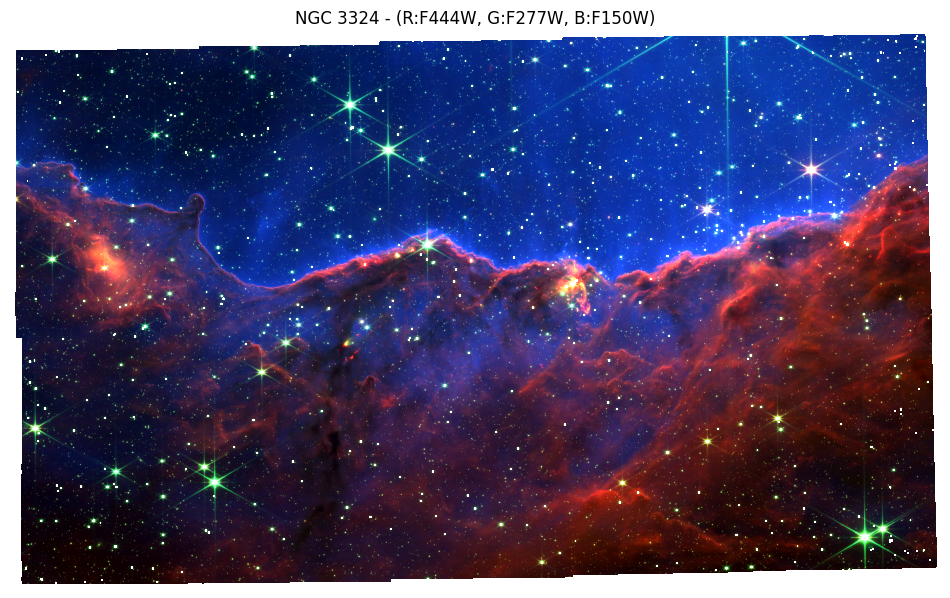

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

with fits.open("jw02731-o001_t017_nircam_clear-f090w_i2d.fits") as hdul:
    img_f090w = hdul['SCI'].data.astype(np.float32)

with fits.open("jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits") as hdul:
    img_f187n = hdul['SCI'].data.astype(np.float32)

with fits.open("jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits") as hdul:
    img_f200w = hdul['SCI'].data.astype(np.float32)

with fits.open("jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits") as hdul:
    img_f335w = hdul['SCI'].data.astype(np.float32)

with fits.open("jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits") as hdul:
    img_f444w = hdul['SCI'].data.astype(np.float32)

with fits.open("jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits") as hdul:
    img_f444w_f470n = hdul['SCI'].data.astype(np.float32)

# Chooseing R, G, B channels from the loaded images
# Example: R = F444W, G = F277W, B = F150W
r_image_raw = img_f444w_f470n
g_image_raw = img_f200w
b_image_raw = img_f187n

# Red Channel
r_finite = r_image_raw[np.isfinite(r_image_raw)]
r_vmin, r_vmax = np.percentile(r_finite, [1.0, 99.0]) 
if r_vmin >= r_vmax:
    r_vmax = r_vmin + 1e-6 if r_vmin != 0 else 1e-6
r_scaled = np.clip(r_image_raw, r_vmin, r_vmax)
if (r_vmax - r_vmin) == 0:
    r_channel = np.zeros_like(r_scaled)
else:
    r_channel = (r_scaled - r_vmin) / (r_vmax - r_vmin)
r_channel = np.clip(r_channel, 0, 1)



# Green Channel
g_finite = g_image_raw[np.isfinite(g_image_raw)]
g_vmin, g_vmax = np.percentile(g_finite, [1.0, 99.0])
if g_vmin >= g_vmax:
    g_vmax = g_vmin + 1e-6 if g_vmin != 0 else 1e-6
g_scaled = np.clip(g_image_raw, g_vmin, g_vmax)
if (g_vmax - g_vmin) == 0:
    g_channel = np.zeros_like(g_scaled)
else:
    g_channel = (g_scaled - g_vmin) / (g_vmax - g_vmin)
g_channel = np.clip(g_channel, 0, 1)


# Blue Channel
b_finite = b_image_raw[np.isfinite(b_image_raw)]
b_vmin, b_vmax = np.percentile(b_finite, [1.0, 99.0])
if b_vmin >= b_vmax:
    b_vmax = b_vmin + 1e-6 if b_vmin != 0 else 1e-6 
b_scaled = np.clip(b_image_raw, b_vmin, b_vmax)
if (b_vmax - b_vmin) == 0:
    b_channel = np.zeros_like(b_scaled)
else:
    b_channel = (b_scaled - b_vmin) / (b_vmax - b_vmin)
b_channel = np.clip(b_channel, 0, 1)


# Stack the channels to create an RGB image
rgb_image_manual = np.stack((r_channel, g_channel, b_channel), axis=2)

plt.figure(figsize=(12, 12)) # Larger figure for detail
plt.imshow(rgb_image_manual, origin='lower')
plt.title("NGC 3324 - (R:F444W, G:F277W, B:F150W)")
plt.axis('off') # Turn off axis numbers and ticks

# Save the image as PNG
plt.savefig("NGC3324_RGB_image.png", bbox_inches='tight', pad_inches=0, dpi=300) # Higher DPI
plt.show()